In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def estudio_STL(df):
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()

    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

    plt.xticks(rotation=90)
    plt.show()
    

def visualizar_adf(df):
    ''' Visualiza el p-valor del estudio de Dickey-Fuller
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''

    adf = adfuller(df)
    print("ADF p-value:" + str(adf[1]))
    

def visualizar_acf(df, n_lags):
    plt.figure(figsize=(16, 10))
    plot_acf(df, lags=n_lags)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.show()
    
def visualizar_pacf(df, n_lags):
    plt.figure(figsize=(16, 6))
    plot_pacf(df, lags=n_lags)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(test.index, test, label='Test', color='green')
        
    plt.plot(test.index, pred, label='Predicción', color='orange')


    plt.xticks(rotation=60)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color='tan')
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(train_s.index, train_s, label='Train', color='tan')
        plt.plot(test.index, test, label='Test', color='green')
    
    plt.plot(test.index, pred, label='Predicción', color='orange')
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(test.index), step=10),   train_s.index.union(test.index)[::10], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_bic_aic(modelo):
    ''' Visualiza los datos de BIC (Criterio de Información Bayesiano) y  AIC (Criterio de Información de Akaike)
    
    Args:
        modelo (ARIMA): modelo ARIMA entrenado
    '''
    
    bic = modelo.bic
    aic = modelo.aic

    print("BIC del modelo ARIMA:", bic)
    print("AIC del modelo ARIMA:", aic)
    
def visualizar_resultados_texto(y_test, y_pred, variable):
    fechas = y_test.index
    for i in range(len(y_test)):
        if variable != '':
            valor_test = y_test[variable][i]
        else:
            valor_test = y_test[i] 
        print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

In [4]:
datos_Fuerteventura = datos_islas[datos_islas['isla'] == 'FUERTEVENTURA'].copy()

# Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_Fuerteventura = datos_Fuerteventura.sort_values(by='fecha')

# Añadimos como índice de los datos la fecha
datos_Fuerteventura.set_index('fecha', inplace=True)

# Variables 
variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']
variables_atm = ['tmin', 'tmed', 'presMax']
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']

objetivo = 'numero_casos' # Variable objetivo
n_dias = 10               # Numero de días correspondiente al conjunto de TEST

# Obtenemos los conjuntos de datos para cada modelo con las variables necesarias para cada uno de ellos
# Modelo Univariable
datos_Fuerteventura_arima_uni = datos_Fuerteventura['numero_casos']
datos_Fuerteventura_arima_mult_covid = datos_Fuerteventura[[objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']]
datos_Fuerteventura_arima_mult_atm = datos_Fuerteventura[[objetivo, 'tmin', 'tmed', 'presMax']]
datos_Fuerteventura_arima_total = datos_Fuerteventura.copy()

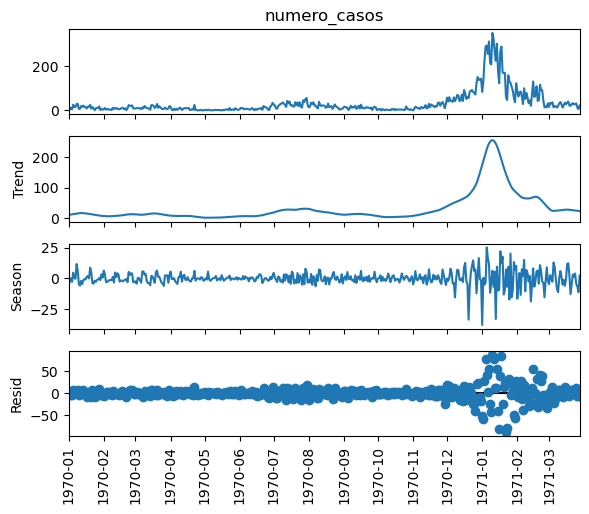

In [5]:
estudio_STL(datos_Fuerteventura_arima_uni)

In [6]:
visualizar_adf(datos_Fuerteventura_arima_uni)

ADF p-value:0.06240639370244957


In [7]:
datos_Fuerteventura_arima_uni_1d = datos_Fuerteventura_arima_uni.diff().dropna()
visualizar_adf(datos_Fuerteventura_arima_uni_1d)

ADF p-value:1.2620515155267858e-05


<Figure size 1600x1000 with 0 Axes>

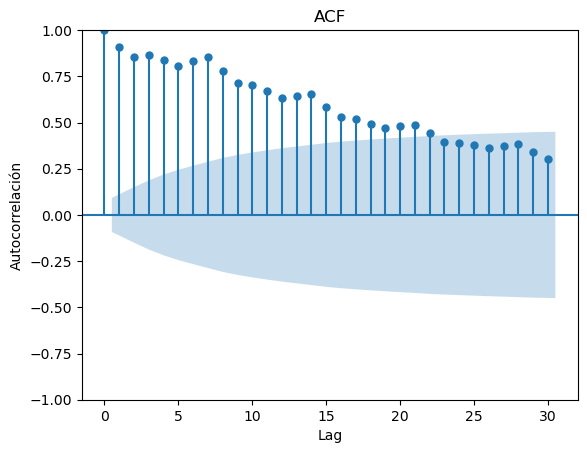

In [8]:
visualizar_acf(datos_Fuerteventura_arima_uni, 30)

<Figure size 1600x600 with 0 Axes>

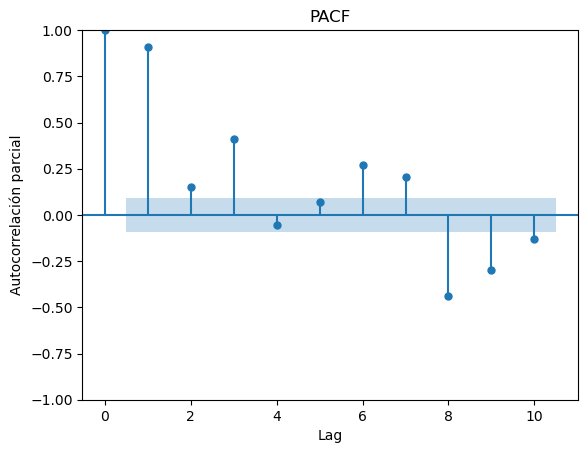

In [9]:
visualizar_pacf(datos_Fuerteventura_arima_uni, 10)

In [10]:
# Parámetros del modelo ARIMA
p = 6
d = 1
q = 3

# Modelo ARIMA univariable

In [11]:
# Conjuntos de entrenamiento y test
train = datos_Fuerteventura_arima_uni.iloc[:len(datos_Fuerteventura_arima_uni) - n_dias]
test =  datos_Fuerteventura_arima_uni.iloc[len(datos_Fuerteventura_arima_uni) - n_dias:]

In [12]:
arima_Fuerteventura = ARIMA(endog=train, order=(p, d, q), freq = 'D')
modelo_arima_Fuerteventura = arima_Fuerteventura.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
visualizar_bic_aic(modelo_arima_Fuerteventura)

BIC del modelo ARIMA: 3815.753644082916
AIC del modelo ARIMA: 3774.8631953284475


In [14]:
pred = modelo_arima_Fuerteventura.forecast(steps=n_dias)

In [15]:
visualizar_resultados_texto(test, pred, '')

2022-03-19: número de casos reales 22, número de casos predichos 28.212825646492277
2022-03-20: número de casos reales 21, número de casos predichos 19.45588416973125
2022-03-21: número de casos reales 29, número de casos predichos 27.945802406290717
2022-03-22: número de casos reales 33, número de casos predichos 33.45843950681967
2022-03-23: número de casos reales 27, número de casos predichos 29.05412623625323
2022-03-24: número de casos reales 29, número de casos predichos 31.548786818758153
2022-03-25: número de casos reales 32, número de casos predichos 35.169036250430295
2022-03-26: número de casos reales 12, número de casos predichos 29.041839282895594
2022-03-27: número de casos reales 6, número de casos predichos 24.143249868415865
2022-03-28: número de casos reales 22, número de casos predichos 29.224964355469627


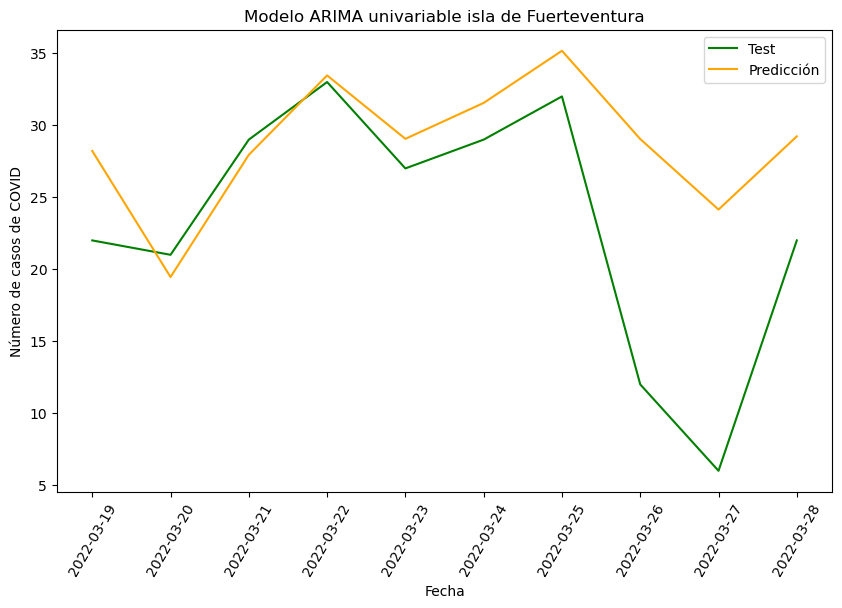

In [16]:
# Título para las visualizaciones
isla = 'Fuerteventura'
tit = 'Modelo ARIMA univariable isla de ' + isla
visualizar_dif_pred_test(test, pred, '', tit)

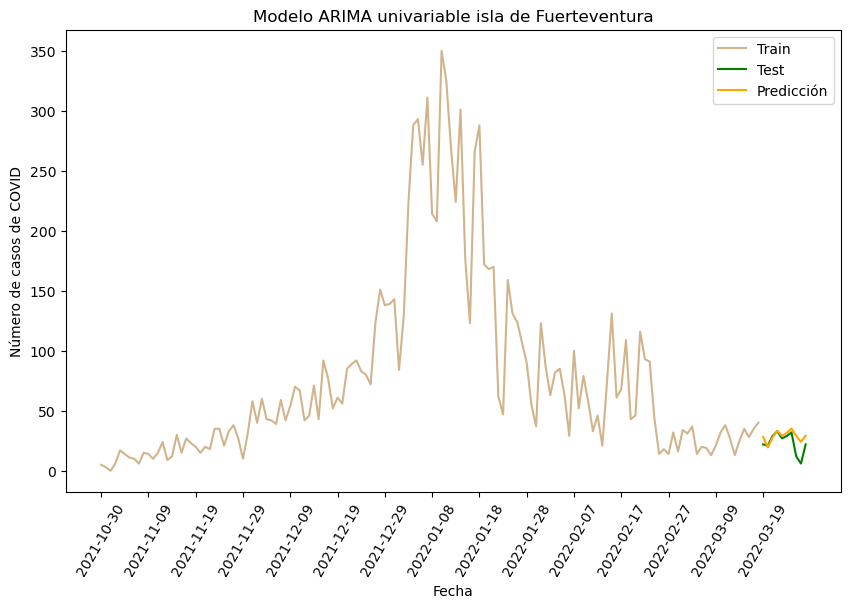

In [17]:
visualizar_historico(train, test, pred, '', 140, tit)

In [18]:
mae, mse, rmse = obtener_errores(test, pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 73.48654470270972
Error absoluto medio (MAE) del modelo: 5.945158138951274
Raíz del error cuadrático medio (RMSE) del modelo: 8.572429334949907


# Modelo ARIMA multivariable con variables de pandemia

In [19]:
train = datos_Fuerteventura_arima_mult_covid.iloc[:len(datos_Fuerteventura_arima_mult_covid) - n_dias]
test =  datos_Fuerteventura_arima_mult_covid.iloc[len(datos_Fuerteventura_arima_mult_covid) - n_dias:]

In [20]:
arima_Fuerteventura = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
modelo_arima_Fuerteventura = arima_Fuerteventura.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
visualizar_bic_aic(modelo_arima_Fuerteventura)

BIC del modelo ARIMA: 3798.998849861943
AIC del modelo ARIMA: 3741.7522216056873


In [22]:
pred = modelo_arima_Fuerteventura.forecast(steps=n_dias, exog=test[variables_covid])

In [23]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 22, número de casos predichos 30.636198454029024
2022-03-20: número de casos reales 21, número de casos predichos 15.211310711246938
2022-03-21: número de casos reales 29, número de casos predichos 19.631433595649675
2022-03-22: número de casos reales 33, número de casos predichos 25.59093939772678
2022-03-23: número de casos reales 27, número de casos predichos 20.198546645756004
2022-03-24: número de casos reales 29, número de casos predichos 19.125533624722912
2022-03-25: número de casos reales 32, número de casos predichos 20.09717851337065
2022-03-26: número de casos reales 12, número de casos predichos 21.185256520784776
2022-03-27: número de casos reales 6, número de casos predichos 15.824387029950714
2022-03-28: número de casos reales 22, número de casos predichos 25.873012260383266


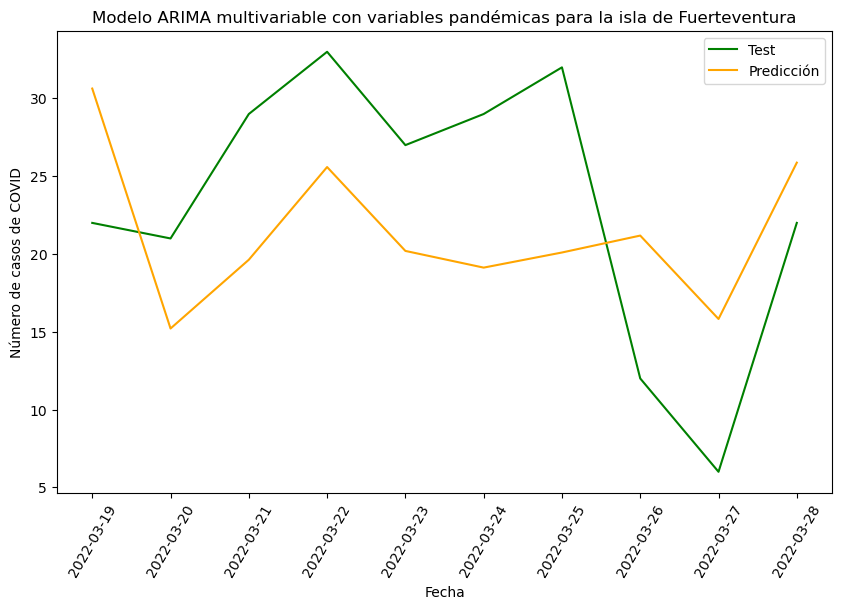

In [24]:
tit = 'Modelo ARIMA multivariable con variables pandémicas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

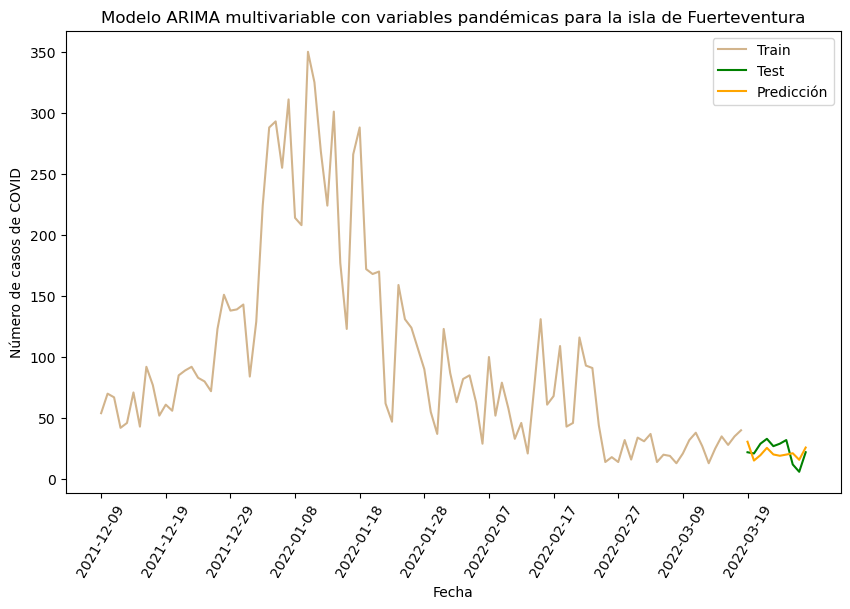

In [25]:
visualizar_historico(train, test, pred, objetivo, 100, tit)

In [26]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 73.20868180049389
Error absoluto medio (MAE) del modelo: 8.266391177667483
Raíz del error cuadrático medio (RMSE) del modelo: 8.556207208833474


# Modelo ARIMA multivariable con variables atmosféricas

In [27]:
train = datos_Fuerteventura_arima_mult_atm.iloc[:len(datos_Fuerteventura_arima_mult_atm) - n_dias]
test =  datos_Fuerteventura_arima_mult_atm.iloc[len(datos_Fuerteventura_arima_mult_atm) - n_dias:]

In [28]:
arima_Fuerteventura = ARIMA(endog=train[objetivo],exog=train[variables_atm], order=(p, d, q), freq = 'D')
modelo_arima_Fuerteventura = arima_Fuerteventura.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
visualizar_bic_aic(modelo_arima_Fuerteventura)

BIC del modelo ARIMA: 3826.819975907565
AIC del modelo ARIMA: 3773.662392526756


In [30]:
pred = modelo_arima_Fuerteventura.forecast(steps=n_dias, exog=test[variables_atm])

In [31]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 22, número de casos predichos 31.622292992731523
2022-03-20: número de casos reales 21, número de casos predichos 21.23119545910527
2022-03-21: número de casos reales 29, número de casos predichos 25.65507948009921
2022-03-22: número de casos reales 33, número de casos predichos 31.927191218857118
2022-03-23: número de casos reales 27, número de casos predichos 30.570122741963836
2022-03-24: número de casos reales 29, número de casos predichos 32.343247501863466
2022-03-25: número de casos reales 32, número de casos predichos 32.0272572860403
2022-03-26: número de casos reales 12, número de casos predichos 33.58259610769842
2022-03-27: número de casos reales 6, número de casos predichos 22.35064346455465
2022-03-28: número de casos reales 22, número de casos predichos 25.318950998755206


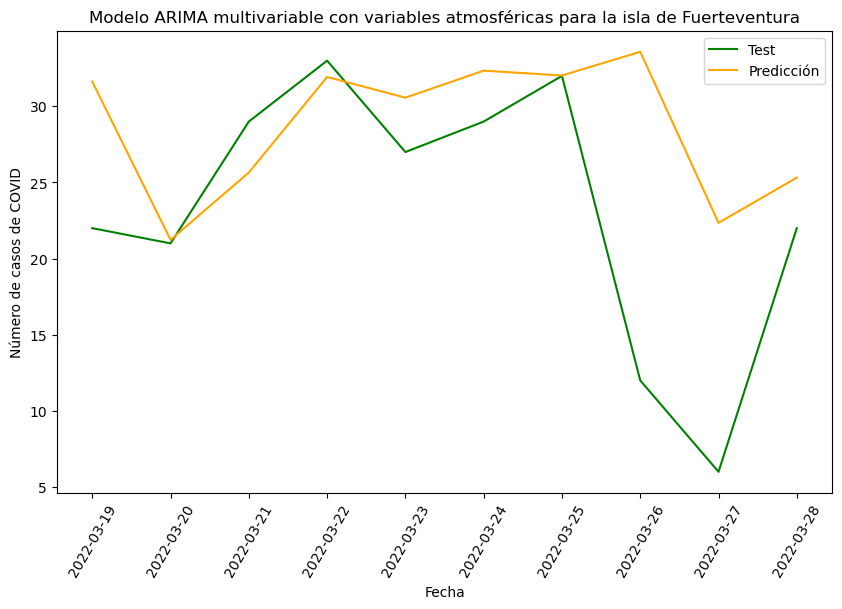

In [32]:
tit = 'Modelo ARIMA multivariable con variables atmosféricas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

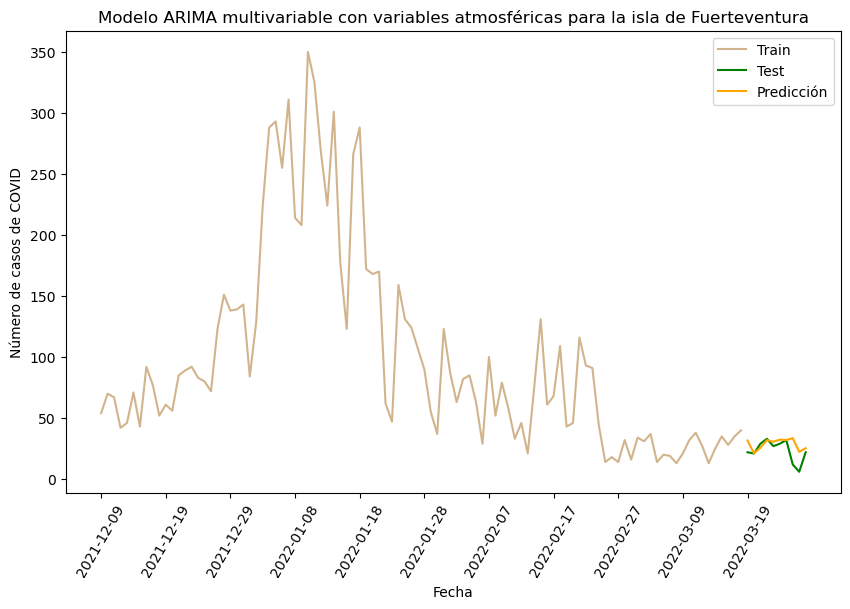

In [33]:
visualizar_historico(train, test, pred, objetivo, 100, tit)

In [34]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 87.30726411398385
Error absoluto medio (MAE) del modelo: 6.246403585375635
Raíz del error cuadrático medio (RMSE) del modelo: 9.343835621091793


# Modelo ARIMA multivariable con todas las variables

In [35]:
train = datos_Fuerteventura_arima_total.iloc[:len(datos_Fuerteventura_arima_total) - n_dias]
test =  datos_Fuerteventura_arima_total.iloc[len(datos_Fuerteventura_arima_total) - n_dias:]

In [36]:
arima_Fuerteventura = ARIMA(endog=train[objetivo],exog=train[variables], order=(p, d, q), freq = 'D')
modelo_arima_Fuerteventura = arima_Fuerteventura.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
visualizar_bic_aic(modelo_arima_Fuerteventura)

BIC del modelo ARIMA: 3835.86190920885
AIC del modelo ARIMA: 3766.3481463262538


In [38]:
pred = modelo_arima_Fuerteventura.forecast(steps=10, exog=test[variables])

In [39]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 22, número de casos predichos 28.91299759705157
2022-03-20: número de casos reales 21, número de casos predichos 20.273600651934316
2022-03-21: número de casos reales 29, número de casos predichos 24.99054564692949
2022-03-22: número de casos reales 33, número de casos predichos 25.621323190218845
2022-03-23: número de casos reales 27, número de casos predichos 20.405286387821207
2022-03-24: número de casos reales 29, número de casos predichos 18.97790603341366
2022-03-25: número de casos reales 32, número de casos predichos 16.23694614235842
2022-03-26: número de casos reales 12, número de casos predichos 20.638433672949418
2022-03-27: número de casos reales 6, número de casos predichos 13.26037466121511
2022-03-28: número de casos reales 22, número de casos predichos 24.773391322705606


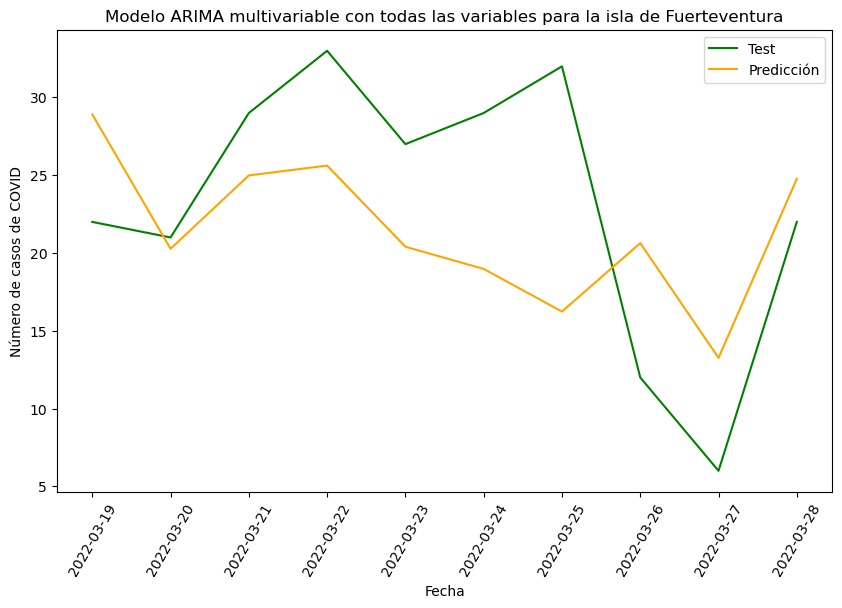

In [40]:
tit = 'Modelo ARIMA multivariable con todas las variables para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

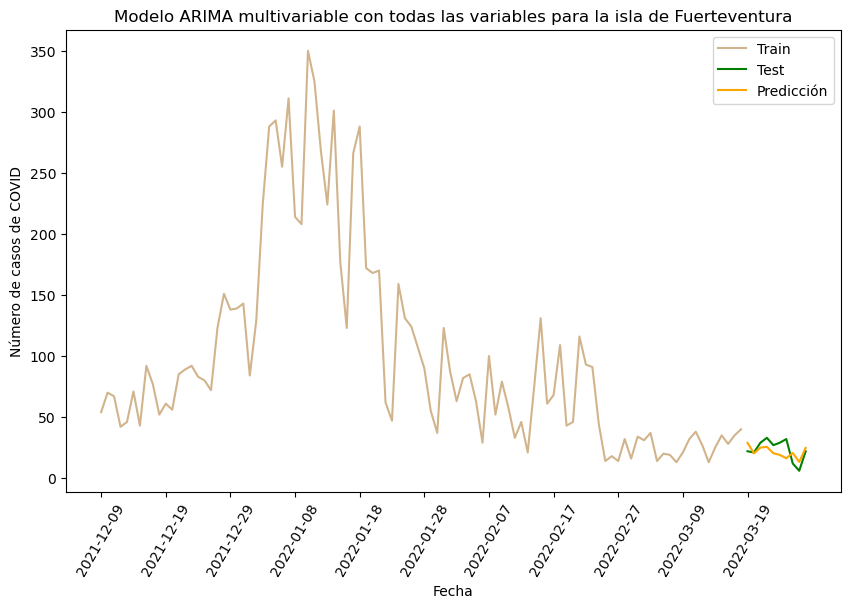

In [41]:
visualizar_historico(train, test, pred, objetivo, 100, tit)

In [42]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 64.62715454549407
Error absoluto medio (MAE) del modelo: 7.007958920124577
Raíz del error cuadrático medio (RMSE) del modelo: 8.039101600645067
